In [111]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import metrics

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

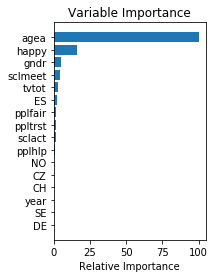

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [8]:
df.groupby("partner").mean()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea
partner,,,,,,,,,,,
1.0,47687.771195,6.492918,3.864353,5.635149,6.062238,5.359266,7.905845,5.030521,2.747856,1.482944,50.979254
2.0,28291.068283,6.512125,3.745373,5.478622,5.913848,5.261008,7.392789,5.512444,2.768985,1.517869,41.316528


In [20]:
# We saw the best results last time when using LASSO regression to select features
from sklearn.linear_model import LogisticRegression

lassoregr = LogisticRegression(penalty ='l1', solver='liblinear')
lassoregr.fit(X_train, y_train)

coeffs = pd.DataFrame(lassoregr.coef_.transpose())
coeffs.index = X_train.columns
np.abs(coeffs).sort_values(by=0, ascending = False)

,0
sclmeet,0.250375
happy,0.230598
SE,0.186157
gndr,0.155462
year,0.148420
CZ,0.090150
NO,0.041529
pplhlp,0.030669
agea,0.029404
ppltrst,0.024485


In [118]:
selected_features1 = list(np.abs(coeffs).sort_values(by=0, ascending = False).index[:10])
selected_features2 = list(set(selected_features).union(set(selected_features1)))

# We'll make 20 iterations, use 8-deep trees, and set our loss function.

params = {'n_estimators': 20,
          'max_depth': 8,
          'learning_rate': 0.07,
          'min_samples_split': 0.1,
          'loss': 'deviance'}


           


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train[selected_features2], y_train)

predict_train = clf.predict(X_train[selected_features2])
predict_test = clf.predict(X_test[selected_features2])

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04091653027823241
Percent Type II errors: 0.2043098745226405

Test set accuracy:
Percent Type I errors: 0.05644171779141104
Percent Type II errors: 0.21104294478527608


In [119]:
results = metrics.classification_report(y_true=y_test, y_pred=predict_test)
print(results)

              precision    recall  f1-score   support

         0.0       0.73      0.91      0.81       505
         1.0       0.75      0.45      0.56       310

   micro avg       0.73      0.73      0.73       815
   macro avg       0.74      0.68      0.68       815
weighted avg       0.74      0.73      0.71       815



In [ ]:
# Lets engineer some features

In [128]:
# lets see what features are extrmely correlated
cm = X_train.corr()
s = cm.unstack()
so = s[s!=1.0].sort_values(kind="quicksort", ascending=False)
so[so>=0.5]

ppltrst  pplfair    0.595645
pplfair  ppltrst    0.595645
dtype: float64

In [147]:
X_train.describe()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CH,CZ,DE,ES,NO,SE,agea_group,ppltrst_pplfair
count,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000,7332.000000
mean,6.444763,3.855837,5.496590,5.915166,5.242771,7.682488,5.188216,2.740998,1.498363,47.272095,0.201173,0.164621,0.003682,0.312602,0.193672,0.124250,1.338516,35.343017
std,0.496973,2.020783,2.225058,2.135412,2.189366,1.750376,1.444856,0.905820,0.500031,18.313567,0.400904,0.370863,0.060576,0.463585,0.395201,0.329889,1.043705,21.360972
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,1.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
50%,6.000000,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,1.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.000000
75%,7.000000,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,2.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,49.000000
max,7.000000,7.000000,10.000000,10.000000,10.000000,10.000000,7.000000,5.000000,2.000000,103.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,100.000000


In [138]:
# (50, 68], (0, 33], (68, 85], (33, 50], (85, 103]
def agea_group(x):
    if x <= 33:
        return 0
    if x <= 50:
        return 1
    if x <= 68:
        return 2
    if x <= 85:
        return 3
    else:
        return 4

In [142]:
# Bing agea
X_train["agea_group"] = X_train.agea.apply(agea_group)
X_test["agea_group"] = X_test.agea.apply(agea_group)

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [158]:
# create an interaction between ppltrst and pplfair
X_train["ppltrst_pplfair"] = X_train["ppltrst"] * X_train["pplfair"]
X_test["ppltrst_pplfair"] = X_test["ppltrst"] * X_test["pplfair"]
# Year can just be binary
X_train["year6"] = (X_train.year == 6.0).astype(int)
X_test["year6"] = (X_test.year == 6.0).astype(int)

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [160]:
# We saw the best results last time when using LASSO regression to select features
lassoregr = LogisticRegression(penalty ='l1', solver='liblinear')
lassoregr.fit(X_train, y_train)

coeffs = pd.DataFrame(lassoregr.coef_.transpose())
coeffs.index = X_train.columns
np.abs(coeffs).sort_values(by=0, ascending = False)

,0
agea_group,0.593270
sclmeet,0.252973
happy,0.231370
SE,0.222907
year,0.164951
gndr,0.161276
CZ,0.121182
agea,0.061710
pplfair,0.051063
pplhlp,0.026958


In [179]:
selected_features1 = list(np.abs(coeffs).sort_values(by=0, ascending = False).index[:14])

# We'll make 20 iterations, use 8-deep trees, and set our loss function.

params = {'n_estimators': 10,
          'max_depth': 8,
          'loss': 'deviance'}


           


# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train[selected_features1], y_train)

predict_train = clf.predict(X_train[selected_features1])
predict_test = clf.predict(X_test[selected_features1])

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.011729405346426624
Percent Type II errors: 0.1782596835788325

Test set accuracy:
Percent Type I errors: 0.06012269938650307
Percent Type II errors: 0.21595092024539878


In [180]:
results2 = metrics.classification_report(y_true=y_test, y_pred=predict_test)
print(results2)

              precision    recall  f1-score   support

         0.0       0.72      0.90      0.80       505
         1.0       0.73      0.43      0.54       310

   micro avg       0.72      0.72      0.72       815
   macro avg       0.73      0.67      0.67       815
weighted avg       0.73      0.72      0.70       815



Not much of a difference when adding these features.